# I. Gaussian Process

# Part 1: Apply Gaussian Process Regression to predict the distribution of f and visualize the result.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(path='input.data'):
    x=[]
    y=[]
    f = open(path, 'r')
    for line in f.readlines():
        datapoint = line.split(' ')
        x.append(float(datapoint[0]))
        y.append(float(datapoint[1]))
    f.close()
    x=np.asarray(x)
    y=np.asarray(y)
    return x,y

In [3]:
def kernel(x1, x2, alpha, length):
    '''
    Use rational quadratic kernel: k(x1,x2)=(1+(x1−x2)^2/2αℓ^2)^(−α) 
    input data x1(n), x2(m) array
    return (n,m) array
    '''
    distance = np.power(x1.reshape(-1,1)-x2.reshape(1,-1),2.0)
    K = np.power(1 + distance/2*alpha*length**2, -alpha)
    
    return K

In [4]:
def predict(line,x,y,K,beta,alpha=1,length=1):
    '''
    vectorize calculate k_x_xstar
    line: sampling in linspace(-60,60)
    X:  (n) ndarray
    y: (n) ndarray
    K: (n,n) ndarray
    beta:
    return: (len(x_line),1) ndarray, (len(x_line),len(x_line)) ndarray
    '''
    k_x_xstar=kernel(x,line,alpha=1,length=1)
    k_xstar_xstar=kernel(line,line,alpha=1,length=1)
    means=k_x_xstar.T @ np.linalg.inv(K) @ y.reshape(-1,1)
    variance=k_xstar_xstar+(1/beta)*np.identity(len(k_xstar_xstar))-k_x_xstar.T @ np.linalg.inv(K) @ k_x_xstar

    return means,variance

In [5]:
# main

def GP(x, y, theta, beta, alpha=1, length=1):
    # Covariance matrix = kernel + whilte noise
    C = kernel(x, x, 1, 1) + 1/beta*theta

    # Get means and variance from range[-60,60]
    line = np.linspace(-60, 60, num=1000)
    M, V = predict(line, x, y, C, beta, alpha, length)
    M_pre = M.reshape(-1)
    V_pre = np.sqrt(np.diag(V))

    # Plot it out
    plt.plot(x, y, 'bo')
    plt.plot(line, M_pre, 'r-')
    plt.fill_between(line, M_pre+V_pre*2, M_pre-V_pre*2, facecolor='salmon')
    plt.xlim(-60, 60)
    plt.show()

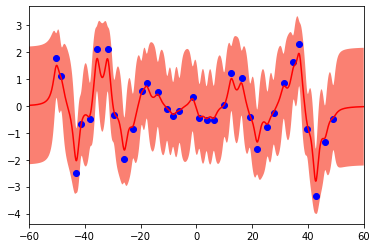

In [6]:
# theta is identical matrix here,beta is 5 here

x ,y =load_data()
theta = np.eye(len(x))
beta = 5

GP(x, y, theta, beta, alpha=1, length=1)

rederence:
    
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html

# Part 2: Optimize the kernel parameters by minimizing negative marginal log-likelihood

In [7]:
from scipy.optimize import minimize

In [8]:
# Define objective function

def objective(x,y,beta):
    '''
    x:  (n) array
    y:  (n) array
    return: objective function
    '''
    def objective_return(the):
        C=kernel(x,x,alpha=the[0], length=the[1]) +(1/beta)*np.identity(len(x))
        L=np.linalg.cholesky(C)
        log_likelihood = 0.5*y.reshape(1,-1) @ np.linalg.inv(C) @ y.reshape(-1,1) + np.sum(np.log(np.diag(L))) + 0.5*len(x)*np.log(2*np.pi)
        return log_likelihood
    return objective_return

In [9]:
# main

def minimize_objective(x, y, beta,theta ,obj_value, init_value):
    for init in init_value:
        for init_scale in init_value:
            mini_obj = minimize(objective(x, y, beta), x0=[init, init_scale], bounds=((1e-5, 1e5), (1e-5, 1e5)))
            if mini_obj.fun < obj_value:
                obj_value = mini_obj.fun
                alpha_optimize, length_scale =mini_obj.x

    # Covariance matrix = kernel + whilte noise    
    C = kernel(x, x,alpha_optimize,length_scale) + 1/beta*theta
    
    # Get means and variance from range[-60,60]
    line = np.linspace(-60, 60, num=1000)
    M, V = predict(line, x, y, C, beta,alpha_optimize,length_scale)
    M_pre = M.reshape(-1)
    V_pre = np.sqrt(np.diag(V))

    # Plot it out
    plt.plot(x, y, 'bo')
    plt.plot(line, M_pre, 'r-')
    plt.fill_between(line, M_pre+V_pre*2, M_pre-V_pre*2, facecolor='salmon')
    plt.xlim(-60, 60)
    plt.show()

C:\Users\Joyce Chou\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


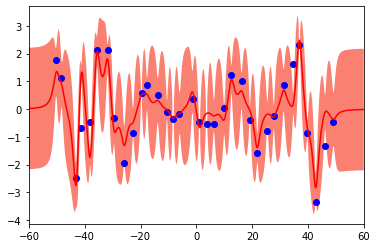

In [11]:
beta =5
x ,y =load_data()
obj_value=1e9
init_value=[1e-3,1e-2,1e-1,0,1e1,1e2,1e3]
theta = np.eye(len(x))
minimize_objective(x, y, beta,theta ,obj_value, init_value)

Only scipy-1.4.1 can work 
Other version: minimize ValueError: `f0` passed has more than 1 dimension.